In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18
import torchaudio.transforms as T
from tqdm import tqdm

In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
device = torch.device('cuda:0')
data_dir = '../input/gtzan-dataset-music-genre-classification/Data/genres_original'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 660000
sr = 22050
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
train_size = 0.8

augmentation_list = ['TimeShift', 'Noise', 'TimeMasking', 'FreqMasking', 'TimeRandomSwap']

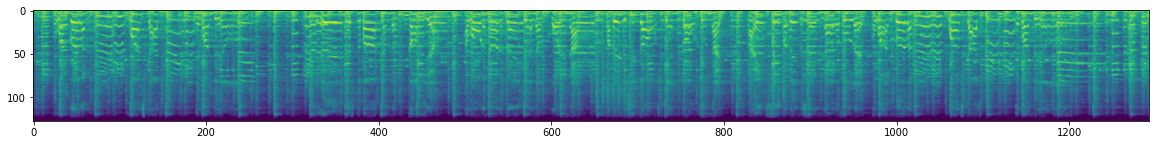

In [6]:
y, _ = librosa.load('../input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav', sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
samples = y
melspec = librosa.feature.melspectrogram(y=samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [7]:
melspec.shape

(128, 1293)

In [8]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 258):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def TimeCycleShift(image, max_shift = 258):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def TimeSwapAugmentation(image, max_b = 258):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def TimeReplyMasking(image, max_b = 258):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 258):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(258)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(258)(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)   
    
    return image

In [9]:
def get_spectrogram(filename, sr = 22050):
    y, _ = librosa.load(filename, sr = sr)
    begin = (len(y) - NUM_SAMPLES) // 2
    samples = y[begin:begin + NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(y=samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)

    return torch.tensor(melspec, dtype=torch.float32)

In [10]:
class GTZAN(Dataset):
    def __init__(self, keys, data = [], labels = []):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [11]:
data = []
labels = []
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
for j in tqdm(range(10)):
    label = j
    music_dir = data_dir + '/' + class_names[j]
    music_files = sorted(os.listdir(music_dir))
    for i in range(len(music_files)):
        filename =  music_dir + '/' + music_files[i]
        if 'jazz.00054.wav' not in filename:
            data.append(get_spectrogram(filename))
            labels.append(label)

100%|██████████| 10/10 [01:29<00:00,  8.94s/it]


In [12]:
len(labels)

999

In [13]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, random_augmentation = False, choice_augmentation = False, augmentation_list = [], aug_probs = []):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    flag_probs = False
    
    if len(aug_probs) > 0:
        flag_probs = True
    
    if choice_augmentation:
        frequences = dict()
        for augmentation_name in augmentation_list:
            frequences[augmentation_name] = 0
        aug_type = np.random.choice(augmentation_list)
    
    for epoch in tqdm(range(epochs)):
        if choice_augmentation:
            frequences[aug_type] += 1
        #Train
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            if random_augmentation or choice_augmentation:
                for i in range(len(y)):
                    if random_augmentation:
                        if flag_probs:
                            aug_type = np.random.choice(augmentation_list, p = aug_probs)
                        else:
                            aug_type = np.random.choice(augmentation_list)
                    if np.random.rand() < 0.5:
                        X[i] = augmentation(X[i], mode = aug_type)
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        
        #Validation
        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        # choose augmentation
        if choice_augmentation:
            aug_accuracy = []
            with torch.no_grad():
                for aug in augmentation_list:
                    sum_accuracy = 0
                    cnt_objects = 0
                    for X, y in valid_loader:
                        for i in range(len(y)):
                            X[i] = augmentation(X[i], mode = aug)
                        X = X.to(device)
                        scores = model(X)
                        preds = scores.cpu().detach().argmax(dim=1)
                        accuracy = float((y == preds).float().sum())
                        sum_accuracy += accuracy
                        cnt_objects += len(y)
                    mean_accuracy = sum_accuracy / cnt_objects
                    aug_accuracy.append(mean_accuracy)
            aug_type = augmentation_list[np.argmin(aug_accuracy)]
    
    frequences_probs = []
    print('Accuracy on the validation: ', best_acc)
    if choice_augmentation:
        for aug_type in augmentation_list:
            frequences_probs.append(frequences[aug_type] / float(epochs))
        print('Frequences:', frequences)
    model.load_state_dict(best_model_wts)
    return model, [train_losses, valid_losses, valid_acc], frequences_probs

In [14]:
def evaluate(model, test_loader):
    model.eval()
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)

    mean_accuracy = sum_accuracy / cnt_objects
    print('************************')
    print('Quality of the model')
    print('Accuracy on test:', mean_accuracy)
    return mean_accuracy

In [15]:
no_augmentation_accuracy18 = []
random_сhoice_accuracy18 = []
choice_after_each_epoch_accuracy18 = []

# Random seed = 1

In [16]:
random_seed = 1

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [15:05<00:00,  9.05s/it]


Accuracy on the validation:  0.8375
************************
Quality of the model
Accuracy on test: 0.71


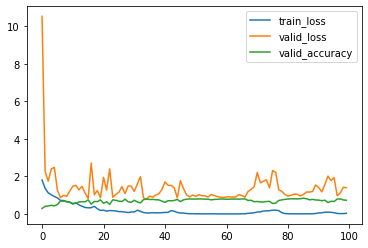

In [17]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 1


100%|██████████| 100/100 [15:42<00:00,  9.43s/it]


Accuracy on the validation:  0.85625
************************
Quality of the model
Accuracy on test: 0.755


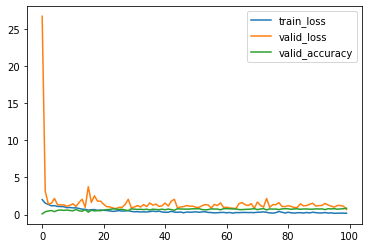

In [18]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 1


100%|██████████| 100/100 [22:43<00:00, 13.64s/it]


Accuracy on the validation:  0.8125
Frequences: {'TimeShift': 0, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 100, 'TimeRandomSwap': 0}
************************
Quality of the model
Accuracy on test: 0.755


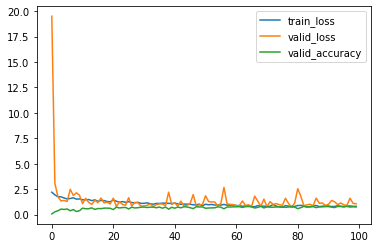

In [19]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 42

In [20]:
random_seed = 42

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [14:58<00:00,  8.99s/it]


Accuracy on the validation:  0.8125
************************
Quality of the model
Accuracy on test: 0.78


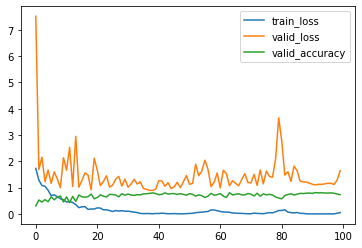

In [21]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 42


100%|██████████| 100/100 [15:44<00:00,  9.44s/it]


Accuracy on the validation:  0.78125
************************
Quality of the model
Accuracy on test: 0.78


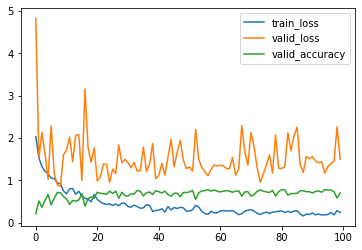

In [22]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 42


100%|██████████| 100/100 [22:44<00:00, 13.65s/it]


Accuracy on the validation:  0.7875
Frequences: {'TimeShift': 1, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 99, 'TimeRandomSwap': 0}
************************
Quality of the model
Accuracy on test: 0.765


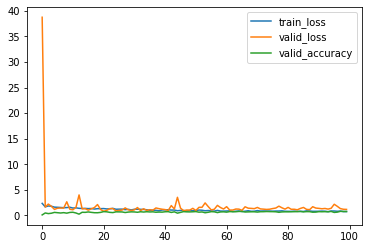

In [23]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 10

In [24]:
random_seed = 10

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [15:01<00:00,  9.01s/it]


Accuracy on the validation:  0.8
************************
Quality of the model
Accuracy on test: 0.775


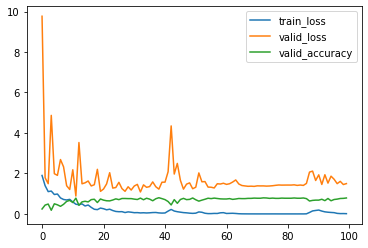

In [25]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 10


100%|██████████| 100/100 [15:44<00:00,  9.45s/it]


Accuracy on the validation:  0.8
************************
Quality of the model
Accuracy on test: 0.775


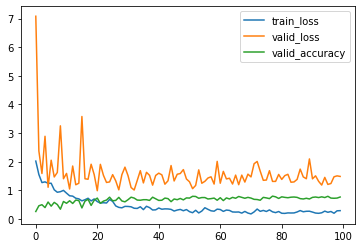

In [26]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 10


100%|██████████| 100/100 [22:45<00:00, 13.65s/it]


Accuracy on the validation:  0.8
Frequences: {'TimeShift': 0, 'Noise': 1, 'TimeMasking': 0, 'FreqMasking': 99, 'TimeRandomSwap': 0}
************************
Quality of the model
Accuracy on test: 0.8


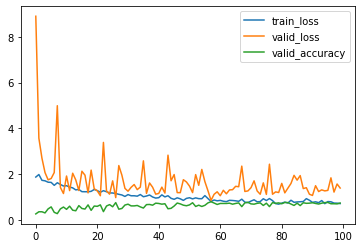

In [27]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 15

In [28]:
random_seed = 15

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [15:00<00:00,  9.00s/it]


Accuracy on the validation:  0.80625
************************
Quality of the model
Accuracy on test: 0.74


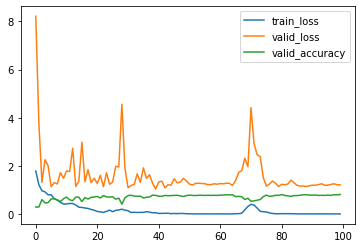

In [29]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 15


100%|██████████| 100/100 [15:45<00:00,  9.45s/it]


Accuracy on the validation:  0.8
************************
Quality of the model
Accuracy on test: 0.725


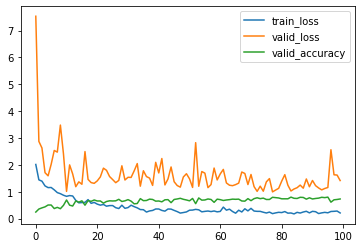

In [30]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 15


100%|██████████| 100/100 [22:47<00:00, 13.67s/it]


Accuracy on the validation:  0.83125
Frequences: {'TimeShift': 1, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 99, 'TimeRandomSwap': 0}
************************
Quality of the model
Accuracy on test: 0.75


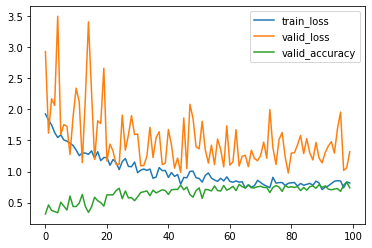

In [31]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random_seed = 23

In [32]:
random_seed = 23

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [15:00<00:00,  9.00s/it]


Accuracy on the validation:  0.75625
************************
Quality of the model
Accuracy on test: 0.71


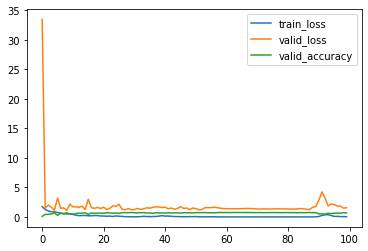

In [33]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 23


100%|██████████| 100/100 [15:45<00:00,  9.46s/it]


Accuracy on the validation:  0.78125
************************
Quality of the model
Accuracy on test: 0.715


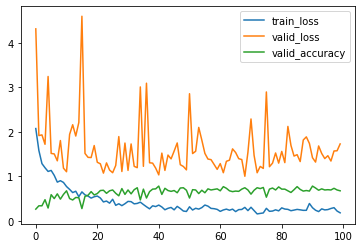

In [34]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

random_сhoice_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Choice of augmentation after each epoch

setting everything to seed 23


100%|██████████| 100/100 [22:49<00:00, 13.69s/it]


Accuracy on the validation:  0.775
Frequences: {'TimeShift': 0, 'Noise': 0, 'TimeMasking': 0, 'FreqMasking': 100, 'TimeRandomSwap': 0}
************************
Quality of the model
Accuracy on test: 0.77


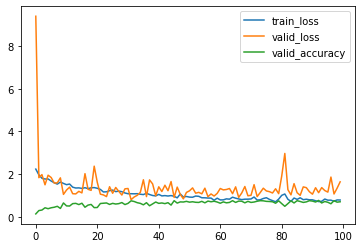

In [35]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

choice_after_each_epoch_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Results

In [36]:
print("resnet18")
no_augmentation_accuracy18 = np.array(no_augmentation_accuracy18) * 100
random_сhoice_accuracy18 = np.array(random_сhoice_accuracy18) * 100
choice_after_each_epoch_accuracy18 = np.array(choice_after_each_epoch_accuracy18) * 100
print("No augmentation")
print("mean:", np.mean(no_augmentation_accuracy18))
print("std:", np.std(no_augmentation_accuracy18))
print("Random сhoice")
print("mean:", np.mean(random_сhoice_accuracy18))
print("std:", np.std(random_сhoice_accuracy18))
print("Choice after each epoch")
print("mean:", np.mean(choice_after_each_epoch_accuracy18))
print("std:", np.std(choice_after_each_epoch_accuracy18))

resnet18
No augmentation
mean: 74.3
std: 3.026549190084311
Random сhoice
mean: 75.0
std: 2.6076809620810595
Choice after each epoch
mean: 76.8
std: 1.74928556845359
